In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_single_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_single_train
from going_modular.OneHeadModel import OneHeadModel

import helper_functions

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
c:\Users\User\.conda\envs\EnvCuda\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\User\.conda\envs\EnvCuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
allow_train = True
freeze_encoder = False
EPOCHS = 40
BATCH_SIZE = 128
shrink_size = None

lr = 3e-4
weight_deacay = 1e-4
T_max = 40
eta_min = 3e-6
num_augs = 2
p_dropout = 0.4
pos_weight = torch.tensor([3.0])

crop_size = 240

# weights for alpha is inverse frequency
# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
# alpha = torch.tensor([0.25, 0.25, 0.25, 0.25, 0.25])

# alpha = [1] * 5
# alpha = [1/1805, 1/370, 1/999, 1/193, 1/295] * 500 
# alpha = 1
# gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

d:\Masoudi\University Project\DR_Project_Binary\helper_functions.py:275: UserWarning: `n` is greater than number of transforms. `n` will be set to 0.
  A.SomeOf([


In [5]:
# load all dataloaders

train_dataloader, val_dataloader, class_names = custom_data_setup_single_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_single_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_dataloader, class_names = custom_data_setup_single_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    shrink_size=shrink_size)

MESSIDOR_dataloader, class_name = custom_data_setup_single_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='MESSIDOR',
    shrink_size=shrink_size)   

IDRID_dataloader, class_name = custom_data_setup_single_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='IDRID',
    shrink_size=shrink_size) 

APTOS_15_test_dataloader, class_name = custom_data_setup_single_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='APTOS_15_test',
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.2489083].


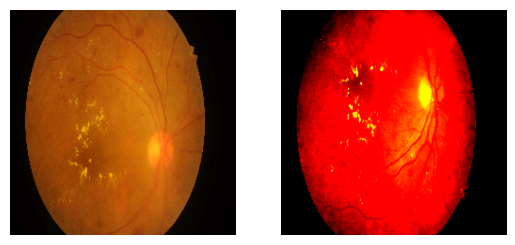

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


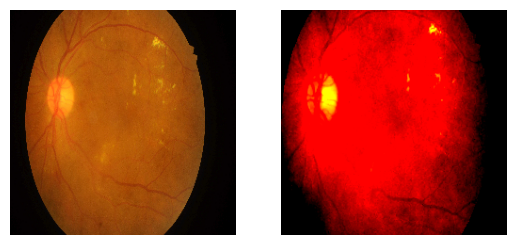

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(2):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, crop_size, crop_size), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
OneHeadModel (OneHeadModel)                                  [32, 3, 240, 240]    [32]                 --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

Custom Focal Loss function

In [9]:
# class FocalLoss_custom(torch.nn.Module):
#     def __init__(self, alpha, gamma, headType=None):
#         super(FocalLoss_custom, self).__init__()
#         self.alpha = alpha.to(device)
#         self.gamma = gamma
#         self.headType = headType
#     def forward(self, inputs, targets):
        
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
#         # apply class weights
#         # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
#         weights = self.alpha.gather(0, targets)

#         pt = torch.exp(-ce_loss)
#         loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
#         # loss = (self.alpha * ((1 - pt) ** self.gamma) * ce_loss)
#         return loss.mean()

In [10]:
from going_modular.focal_loss import FocalLoss

In [11]:
# Define loss and optimizer

# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)

loss_fn_classification = nn.BCEWithLogitsLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
# loss_fn_classification = FocalLoss_custom(headType='classification', alpha=alpha, gamma=gamma).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='multi-class', num_classes=5).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='binary', num_classes=2).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [ ]:
torch.cuda.empty_cache()

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    train_results, val_results = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=EPOCHS,
                device=device)
    
    helper_functions.plot_t_SNE(model=model,
                            dataloader=val_dataloader,
                            NUM_ITER=2000)
    
    utils.save_model(model=model, target_dir='models', model_name=f'main_train_model.pth')


    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
else:
    model.load_state_dict(torch.load('models/single_train_model.pth', weights_only=True, map_location=device))

  2%|▎         | 1/40 [00:53<34:53, 53.69s/it]

Epoch 1, Learning Rate: 0.0002995422240593695
loss_classification_train: 0.8232 | loss_classification_validation: 0.5862 | acc_classification_validation: 0.6754


  5%|▌         | 2/40 [01:27<26:37, 42.04s/it]

Epoch 2, Learning Rate: 0.00029817171857837797
loss_classification_train: 0.6744 | loss_classification_validation: 0.5258 | acc_classification_validation: 0.7107


  8%|▊         | 3/40 [02:01<23:30, 38.13s/it]

Epoch 3, Learning Rate: 0.000295896933179055
loss_classification_train: 0.5897 | loss_classification_validation: 0.5107 | acc_classification_validation: 0.7313


 10%|█         | 4/40 [02:35<21:53, 36.50s/it]

Epoch 4, Learning Rate: 0.0002927318926698303
loss_classification_train: 0.5504 | loss_classification_validation: 0.4945 | acc_classification_validation: 0.7360


 12%|█▎        | 5/40 [03:08<20:44, 35.57s/it]

Epoch 5, Learning Rate: 0.00028869611057792606
loss_classification_train: 0.5250 | loss_classification_validation: 0.4804 | acc_classification_validation: 0.7366


 15%|█▌        | 6/40 [03:42<19:50, 35.00s/it]

Epoch 6, Learning Rate: 0.0002838144688419726
loss_classification_train: 0.5069 | loss_classification_validation: 0.4738 | acc_classification_validation: 0.7439


 18%|█▊        | 7/40 [04:16<19:02, 34.61s/it]

Epoch 7, Learning Rate: 0.0002781170644065827
loss_classification_train: 0.4871 | loss_classification_validation: 0.4585 | acc_classification_validation: 0.7555


 20%|██        | 8/40 [04:50<18:17, 34.31s/it]

Epoch 8, Learning Rate: 0.0002716390236646797
loss_classification_train: 0.4791 | loss_classification_validation: 0.4574 | acc_classification_validation: 0.7566


 22%|██▎       | 9/40 [05:24<17:38, 34.16s/it]

Epoch 9, Learning Rate: 0.0002644202858916046
loss_classification_train: 0.4682 | loss_classification_validation: 0.4498 | acc_classification_validation: 0.7624


 25%|██▌       | 10/40 [05:58<17:03, 34.12s/it]

Epoch 10, Learning Rate: 0.0002565053570062023
loss_classification_train: 0.4512 | loss_classification_validation: 0.4433 | acc_classification_validation: 0.7750


 28%|██▊       | 11/40 [06:32<16:27, 34.06s/it]

Epoch 11, Learning Rate: 0.0002479430351770323
loss_classification_train: 0.4408 | loss_classification_validation: 0.4454 | acc_classification_validation: 0.7661


 30%|███       | 12/40 [07:06<15:52, 34.01s/it]

Epoch 12, Learning Rate: 0.00023878610996543221
loss_classification_train: 0.4388 | loss_classification_validation: 0.4412 | acc_classification_validation: 0.7608


 32%|███▎      | 13/40 [07:39<15:16, 33.94s/it]

Epoch 13, Learning Rate: 0.00022909103686031835
loss_classification_train: 0.4262 | loss_classification_validation: 0.4699 | acc_classification_validation: 0.7624


 35%|███▌      | 14/40 [08:13<14:43, 33.96s/it]

Epoch 14, Learning Rate: 0.00021891758921132264
loss_classification_train: 0.4160 | loss_classification_validation: 0.4402 | acc_classification_validation: 0.7798


 38%|███▊      | 15/40 [08:47<14:07, 33.90s/it]

Epoch 15, Learning Rate: 0.0002083284897062158
loss_classification_train: 0.4086 | loss_classification_validation: 0.4385 | acc_classification_validation: 0.7745


 40%|████      | 16/40 [09:20<13:29, 33.72s/it]

Epoch 16, Learning Rate: 0.00019738902366467966
loss_classification_train: 0.4049 | loss_classification_validation: 0.4382 | acc_classification_validation: 0.7882


 42%|████▎     | 17/40 [09:54<12:54, 33.67s/it]

Epoch 17, Learning Rate: 0.00018616663653260194
loss_classification_train: 0.3977 | loss_classification_validation: 0.4503 | acc_classification_validation: 0.7840


 45%|████▌     | 18/40 [10:27<12:18, 33.55s/it]

Epoch 18, Learning Rate: 0.00017473051805847427
loss_classification_train: 0.3908 | loss_classification_validation: 0.4421 | acc_classification_validation: 0.7998


 48%|████▊     | 19/40 [11:01<11:44, 33.56s/it]

Epoch 19, Learning Rate: 0.00016315117571558496
loss_classification_train: 0.3773 | loss_classification_validation: 0.4413 | acc_classification_validation: 0.7919


 50%|█████     | 20/40 [11:35<11:12, 33.62s/it]

Epoch 20, Learning Rate: 0.00015149999999999997
loss_classification_train: 0.3705 | loss_classification_validation: 0.4324 | acc_classification_validation: 0.7940


 52%|█████▎    | 21/40 [12:08<10:39, 33.67s/it]

Epoch 21, Learning Rate: 0.000139848824284415
loss_classification_train: 0.3681 | loss_classification_validation: 0.4497 | acc_classification_validation: 0.7877


 55%|█████▌    | 22/40 [12:42<10:07, 33.75s/it]

Epoch 22, Learning Rate: 0.00012826948194152572
loss_classification_train: 0.3508 | loss_classification_validation: 0.4384 | acc_classification_validation: 0.7914


 57%|█████▊    | 23/40 [13:16<09:34, 33.79s/it]

Epoch 23, Learning Rate: 0.00011683336346739804
loss_classification_train: 0.3461 | loss_classification_validation: 0.4515 | acc_classification_validation: 0.7935


 60%|██████    | 24/40 [13:50<09:00, 33.77s/it]

Epoch 24, Learning Rate: 0.00010561097633532029
loss_classification_train: 0.3418 | loss_classification_validation: 0.4412 | acc_classification_validation: 0.7766


In [ ]:
if allow_train:
    helper_functions.plot_loss_curves_main_train(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device)

per class scores: precision: [0.99603489 0.99462366] | recall: [0.99445764 0.99615385] | f1_score: [0.99524564 0.99538816]
average scores: precision: 0.995329274428044 | recall: 0.9953057433461234 | f1_score: 0.9953169023949637
accuracy: 0.9953179867342957
QWK:  0.9906338104945419


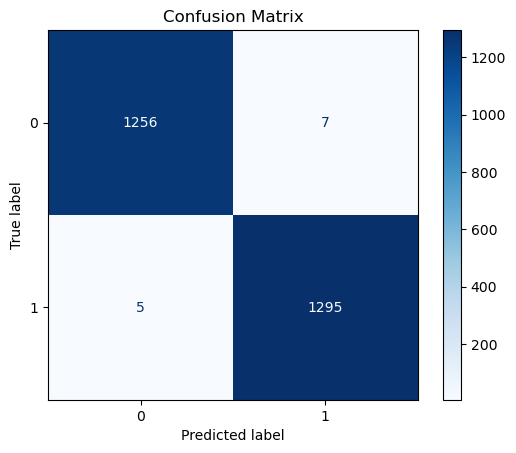

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=exp_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device)

per class scores: precision: [0.73367572 0.95538058] | recall: [0.98328417 0.50068776] | f1_score: [0.84033613 0.65703971]
average scores: precision: 0.8445281463808221 | recall: 0.7419859635170465 | f1_score: 0.7486879228225587
accuracy: 0.7821100917431193
QWK:  0.5192030052714133


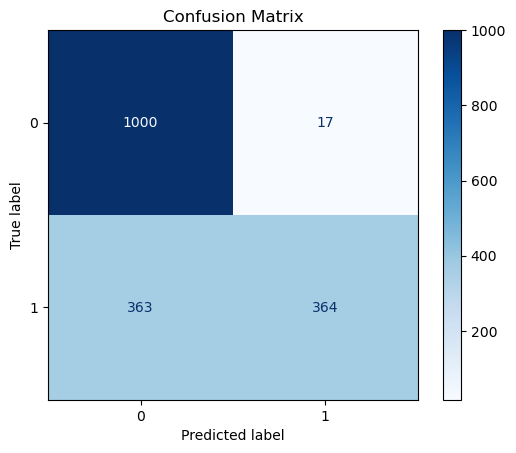

In [ ]:
MESSIDOR_test_results = engine.test_step(model=model,
            dataloader=MESSIDOR_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device)

per class scores: precision: [0.86923077 0.95076923] | recall: [0.87596899 0.94785276] | f1_score: [0.87258687 0.94930876]
average scores: precision: 0.91 | recall: 0.9119108764921291 | f1_score: 0.9109478141736207
accuracy: 0.9274725274725275
QWK:  0.8218966846569005


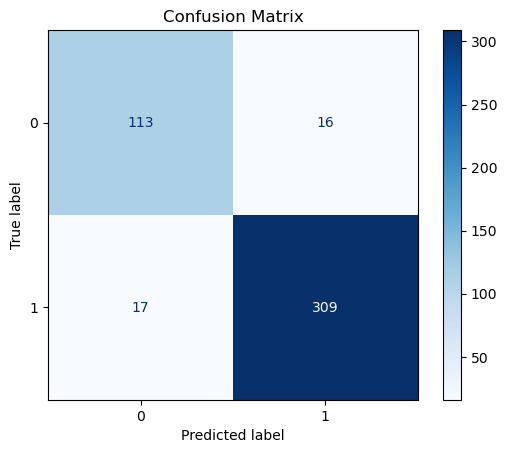

In [ ]:
IDRID_test_results = engine.test_step(model=model,
            dataloader=IDRID_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device)

per class scores: precision: [0.83401743 0.67042116] | recall: [0.91488124 0.48743146] | f1_score: [0.87257989 0.56446625]
average scores: precision: 0.752219294370857 | recall: 0.701156349486572 | f1_score: 0.7185230689827447
accuracy: 0.8028408242496641
QWK:  0.4411300244170012


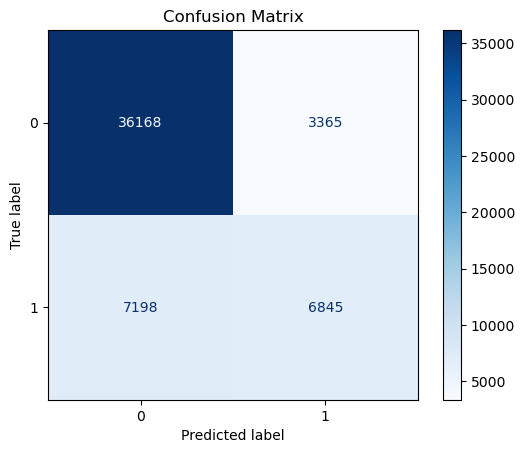

In [ ]:
APTOS_15_test_results = engine.test_step(model=model,
            dataloader=APTOS_15_test_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device)

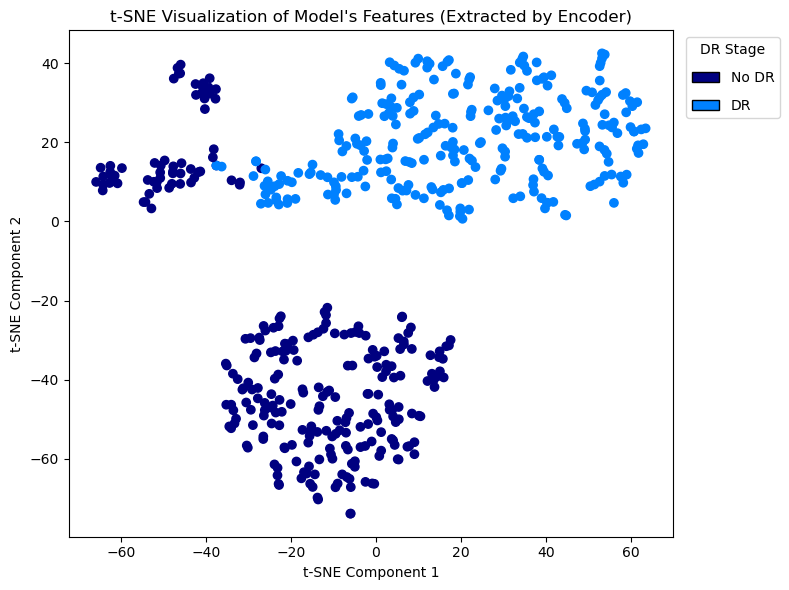

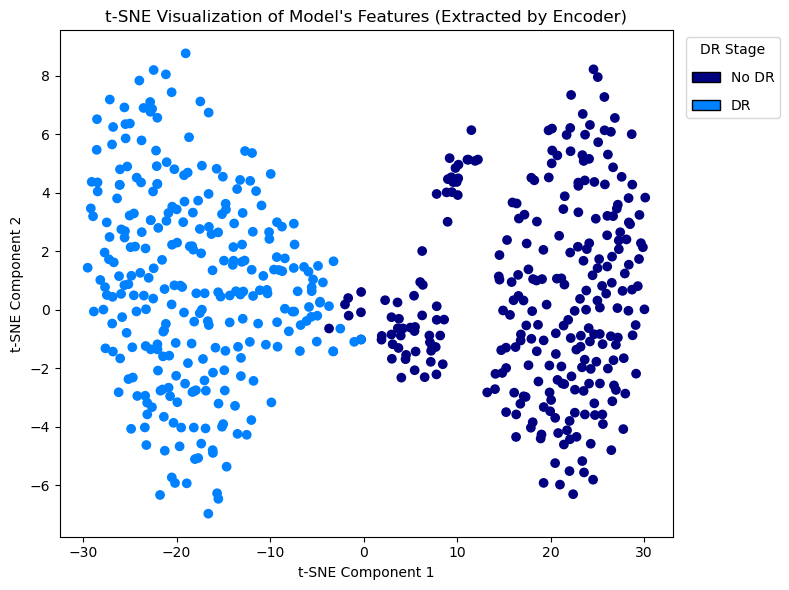

In [ ]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=test_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)